<a href="https://colab.research.google.com/github/JessicaFB/SmartHouse_HackfromHome2021/blob/main/SmartHouse_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-&amp;-Data" data-toc-modified-id="Import-Packages-&amp;-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages &amp; Data</a></span></li><li><span><a href="#EDA-&amp;-Cleaning" data-toc-modified-id="EDA-&amp;-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA &amp; Cleaning</a></span></li></ul></div>

# Import Packages & Data

In [2]:
# Import necessary packages

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
# Import data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
# from my local computer, commenting out
# data = pd.read_csv('Data/CLEAN_REFIT_081116/CLEAN_House3.csv')
data = pd.read_csv('drive/MyDrive/HackfromHome2021/Data/CLEAN_REFIT_081116/CLEAN_House3.csv')
df = pd.DataFrame(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA & Cleaning

Preview data

In [8]:
# Preview data

df.head()

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,2013-09-25 19:21:09,1380136869,387,0,0,86,0,0,0,145,0,0,0
1,2013-09-25 19:21:16,1380136876,386,0,0,86,0,0,0,144,0,0,0
2,2013-09-25 19:21:23,1380136883,383,0,0,86,0,0,0,144,0,0,0
3,2013-09-25 19:21:30,1380136890,388,0,0,87,0,0,0,145,0,0,0
4,2013-09-25 19:21:37,1380136897,388,0,0,86,0,0,0,145,0,0,0


In [20]:
# Get info

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6585967 entries, 2013-09-25 19:21:09 to 2015-06-02 10:55:42
Data columns (total 10 columns):
 #   Column      Dtype
---  ------      -----
 0   Aggregate   int64
 1   Appliance1  int64
 2   Appliance2  int64
 3   Appliance3  int64
 4   Appliance4  int64
 5   Appliance5  int64
 6   Appliance6  int64
 7   Appliance7  int64
 8   Appliance8  int64
 9   Appliance9  int64
dtypes: int64(10)
memory usage: 552.7 MB


We're going to use datetime index rather than unix. Could use unix, however since that's universal time, having local daily hours will be more relevant to energy usage. So we will use local time instead. 

Converting index to datetime will make it easy to plot energy usage. 

In [9]:
# Convert index to datetime

df.index = pd.to_datetime(df.Time)

Now that we have datetime as index we can drop the Time column. I'll drop Unix as well, and we can always come back and add it if we decide we need/want to use it. I'm going to check for issues too and if no issues, will come back and drop that column as well. 

In [10]:
df = df.drop(['Time','Unix'], axis=1)
df.head()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
Time,,,,,,,,,,,
2013-09-25 19:21:09,387,0,0,86,0,0,0,145,0,0,0
2013-09-25 19:21:16,386,0,0,86,0,0,0,144,0,0,0
2013-09-25 19:21:23,383,0,0,86,0,0,0,144,0,0,0
2013-09-25 19:21:30,388,0,0,87,0,0,0,145,0,0,0
2013-09-25 19:21:37,388,0,0,86,0,0,0,145,0,0,0


From the 'CLEAN_READ_ME_081116.txt' file with the dataset we used, it says that the Issues column "is set to 1 if the sum of the sub-metering (IAMs) is greater than that of the household aggregate. In these cases the data should be discarded or noted that there is a discrepancy." So we will remove data that satisfy these criteria. 

Let's calculate and see how much of our data this represents.

In [11]:
# Percentage of data with discrepancy

print(f'Percentage of data w/discrepancy: \n{round(len(df[df.Issues == 1])/len(df)*100,2)} %')

Percentage of data w/discrepancy: 
5.84 %


Cool. That's not too much at all. We'll go ahead and remove that data now and then drop the issues column. 

In [12]:
# Drop data w/discrepancy
df = df[df.Issues == 0]

# Drop Issues column
df = df.drop('Issues', axis=1)

# Preview
df.head()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
Time,,,,,,,,,,
2013-09-25 19:21:09,387,0,0,86,0,0,0,145,0,0
2013-09-25 19:21:16,386,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:23,383,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:30,388,0,0,87,0,0,0,145,0,0
2013-09-25 19:21:37,388,0,0,86,0,0,0,145,0,0


Let's preview our Aggregate column, which represents all appliances. 

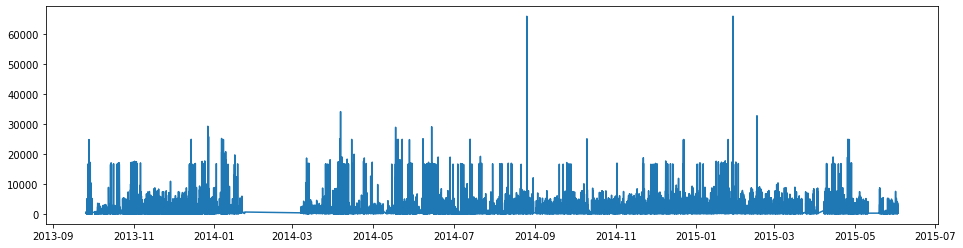

In [13]:
plt.figure(figsize=(16,4))
plt.plot(df.Aggregate)
plt.show()

We can see some standout peaks here in August, late summer of 2014 as well as February, in winter 2015. We might expect to see some peaks if it were a particularly hot summer or heat wave as well as a particularly cold time. So while these stand out, they make sense where they're located.

In [14]:
df.columns

Index(['Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4',
       'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9'],
      dtype='object')

We know what types of appliances are used for each appliance here, as it is listed in the 'CLEAN_READ_ME_081116.txt' file that was included with the dataset. There are 20 different homes (1-21, skipping 14) and the appliance number is associated with different appliances for each home. 

While we could manually adjust it here, it would need to be done manually for each home. Perhaps we could create an excel sheet, enter the data in manually and read it in from there.

We also have a metadata file that shows:
- Occupancy (# of residents)
- Construction Year
- Appliances Owned
- Type (Detached, Semi-detached, Mid-terrace)
- Size (# of bedrooms) 

We can read in and utilize this dataset as well. 

For now I will give the details on the particular house we are looking at here, House 3. 

- Occupancy: 2
- Construction Year: 1988
- Appliances Owned: 27
- Type: Detached
- Size: 3 Bedroom

## Subplots: Usage - House 3

Note, these subplots include multiple years, this will be important for modeling, however we can slice the time series to get a closer look or perhaps begin modeling to get greater insights. 

The subplot below takes a while to run.

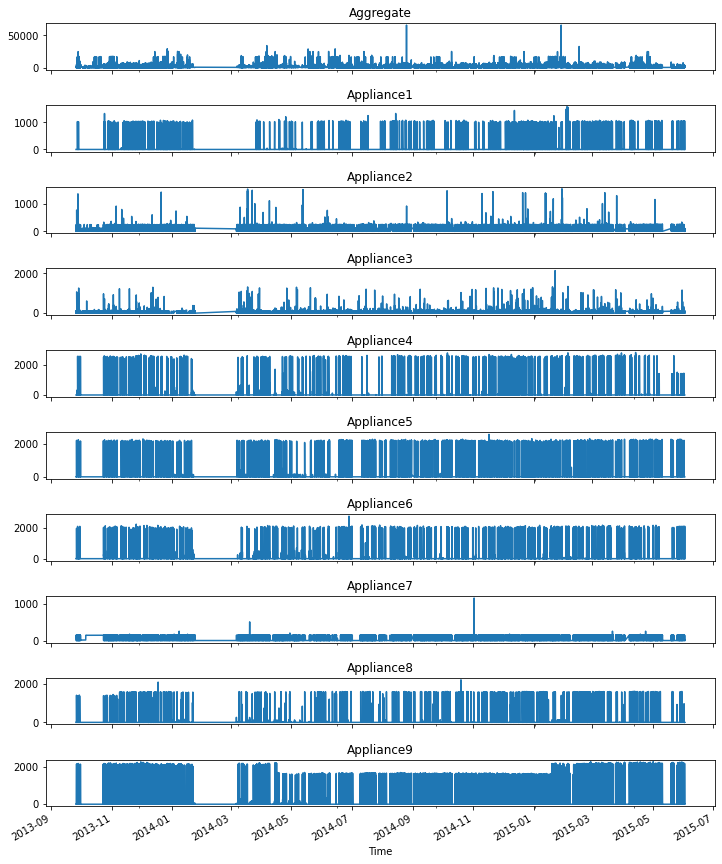

In [15]:
# Subplots; share x-axis
fig, axes = plt.subplots(len(df.columns), 1, figsize=(12, 16), sharex=True)

# Adjust space between
fig.subplots_adjust(hspace=.75)

for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].plot(ax=ax, title=col, legend=False)

We never looked at the summary statistics. Let's go ahead and take a look now.

In [18]:
# Summary statistics
df.describe().round()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
count,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0,6585967.0
mean,696.0,1.0,52.0,35.0,43.0,43.0,24.0,45.0,2.0,15.0
std,1032.0,39.0,56.0,44.0,308.0,291.0,191.0,66.0,53.0,165.0
min,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,382.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,630.0,0.0,94.0,88.0,0.0,0.0,0.0,143.0,0.0,0.0
max,65836.0,1567.0,1550.0,2137.0,2795.0,2567.0,2746.0,1169.0,2220.0,2277.0


These data are active power in watts, measured every 8 seconds. We could divide by 1000 to make it kilowatts, however for now I'm going to leave it. 

In [19]:
df.head()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
Time,,,,,,,,,,
2013-09-25 19:21:09,387,0,0,86,0,0,0,145,0,0
2013-09-25 19:21:16,386,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:23,383,0,0,86,0,0,0,144,0,0
2013-09-25 19:21:30,388,0,0,87,0,0,0,145,0,0
2013-09-25 19:21:37,388,0,0,86,0,0,0,145,0,0


Let's look at daily average consumption by appliance.

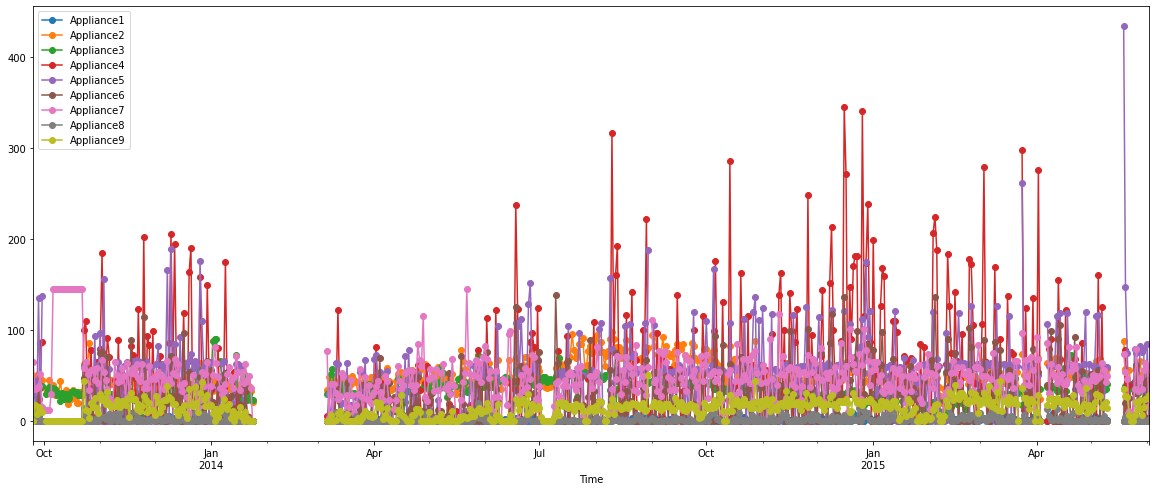

In [37]:
# Drop Aggregate
ts_appliances = df.drop('Aggregate', axis=1)
# Daily mean consumption by appliance
ts_appliances.resample("D").mean().plot(style="-o", figsize=(20, 8));

We have a lot of data crammed in here, but we can see that Appliance #4 seems to consume the most energy, followed by appliance #5. These appliances are the tumble dryer and the dishwasher respectively. 

This makes sense as both generate a considerable amount of heat for an extended time to perform their functions.

Let's take a look at the Aggregate consumption for comparison, to see the total, as this house actually has 27 appliances and potentially heating and cooling, although we don't know this for certain, as the data do not specify. 

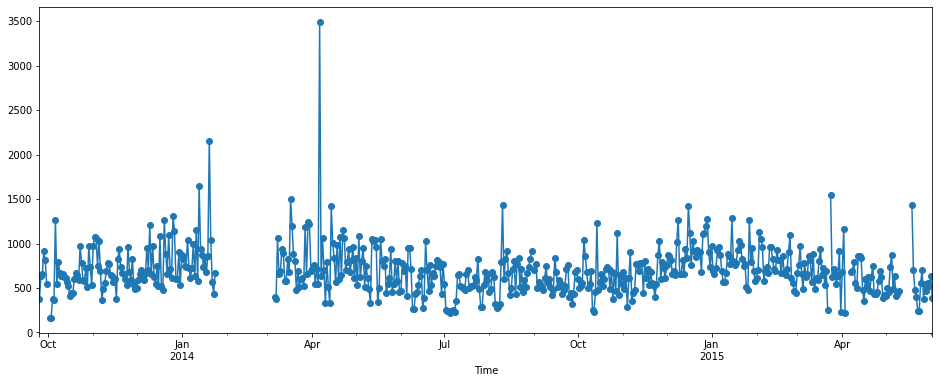

In [41]:
# Aggregate
ts_aggregate = df['Aggregate']
# Daily mean consumption totals
ts_aggregate.resample("D").mean().plot(style="-o", figsize=(16, 6));

Let's take a look at weekly.

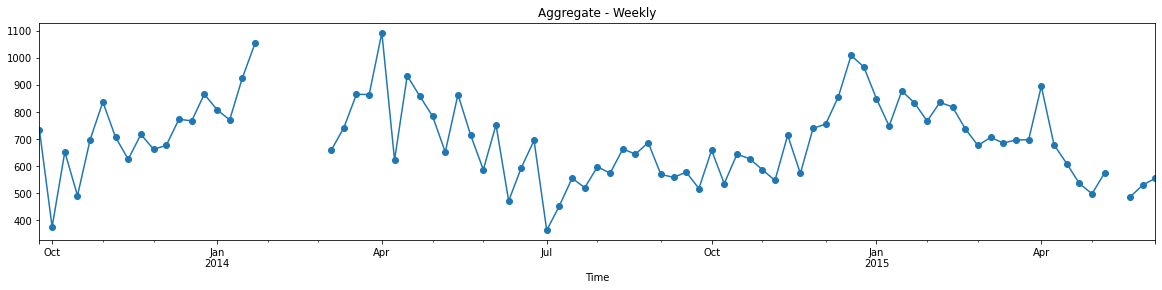

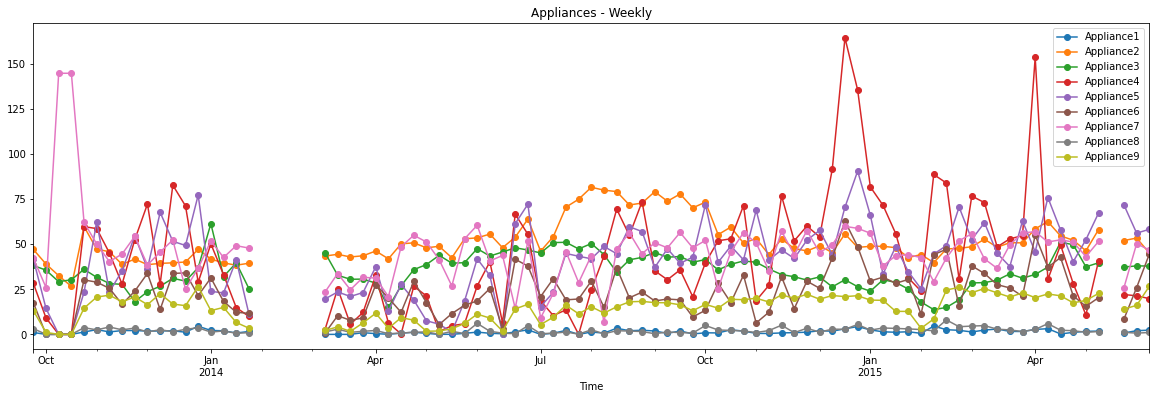

In [48]:
# Weekly mean consumption totals
ts_aggregate.resample("W").mean().plot(style="-o", figsize=(20, 4))
plt.title('Aggregate - Weekly')
plt.show()

# Weekly mean consumption by appliance
ts_appliances.resample("W").mean().plot(style="-o", figsize=(20, 6))
plt.title('Appliances - Weekly')
plt.show()

Interestingly here we can see in October of 2014 there was a huge spike in use of Appliance 7, which is a Television Site. It was noted in the readme file included with the data set that the "Television and Computer Site may consist of multiple appliances, e.g. Television, SkyBox, DvD Player, Computer, Speakers, etc." So this is a compilation of appliances. 

We can also see a spike in Appliance 2 from July through October of 2014. Appliance 2 represents a Freezer. 

Also a note, the missing data in February of 2014 it said this was "due to a number of factors, including household internet failure, hardware failures, network routing issues, etc."